# Sawtooth Wave Generator

A *sawtooth wave* is a periodic function that starts at an initial value, ramps up at a fixed rate until reaching an end value, and then drops to the starting value and repeats.

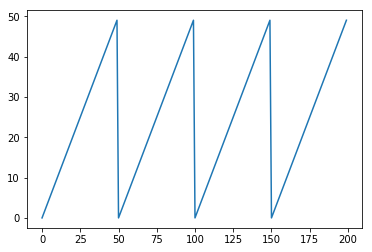

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def saw(x):
    return x % 50

x = np.arange(0, 200)

plt.plot(x, saw(x))

In [2]:
import magma as m
m.set_mantle_target('ice40')

In [3]:
import mantle
from loam.boards.icestick import IceStick

N = 8

icestick = IceStick()
icestick.Clock.on()
for i in range(N):
    icestick.J3[i].output().on()
    
main = icestick.main()

counter = mantle.Counter(32)
sawtooth = counter.O[8:16]

m.wire( sawtooth, main.J3 )

m.EndDefine()

import lattice ice40
import lattice mantle40


In [4]:
m.compile('build/sawtooth', main)

In [5]:
%%bash
cd build
cat sawtooth.pcf
yosys -q -p 'synth_ice40 -top main -blif sawtooth.blif' sawtooth.v
arachne-pnr -q -d 1k -o sawtooth.txt -p sawtooth.pcf sawtooth.blif 
icepack sawtooth.txt sawtooth.bin
iceprog sawtooth.bin

set_io J3[7] 44
set_io J3[6] 45
set_io J3[5] 47
set_io J3[4] 48
set_io J3[3] 56
set_io J3[2] 60
set_io J3[1] 61
set_io J3[0] 62
set_io CLKIN 21


init..
cdone: high
reset..
cdone: low
flash ID: 0x20 0xBA 0x16 0x10 0x00 0x00 0x23 0x64 0x34 0x65 0x03 0x00 0x71 0x00 0x26 0x27 0x12 0x16 0xD3 0xE4
file size: 32220
erase 64kB sector at 0x000000..
programming..
reading..
VERIFY OK
cdone: high
Bye.


We can wire up the GPIO pins to a logic analyzer to verify that our circuit produces the correct sawtooth waveform.

![](images/sawtooth.png)

We can also use Saleae's [export data](https://support.saleae.com/hc/en-us/articles/115005986806-Saving-Loading-and-Exporting-Data) feature to output a [csv file](data/saw-capture.csv). We'll load this data into Python and plot the results.

In [6]:
import csv
import magma as m
with open("data/saw-capture.csv") as saw_capture_csv:
    csv_reader = csv.reader(saw_capture_csv)
    next(csv_reader, None)  # skip the headers
    rows = [row for row in csv_reader]
timestamps = [float(row[0]) for row in rows]
values = [m.bitutils.seq2int(tuple(int(x) for x in row[1:])) for row in rows]

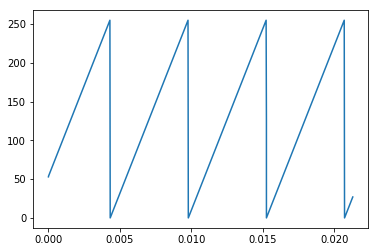

In [7]:
import matplotlib.pyplot as plt
plt.plot(timestamps[:1000], values[:1000], "-")